In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import adjusted_mutual_info_score as mi
# from sklearn.metrics import homogeneity_score as hs
from sklearn.metrics import confusion_matrix
import matplotlib
import seaborn as sns
from scipy import stats
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE


In [2]:
# Load all required data
from google.colab import drive
drive.mount('/content/gdrive')
% cd '/content/gdrive/MyDrive/Colab Notebooks/Unsupervised'
essayEncode_file = 'essayEncodings_BERT.npz'
essayClass_file = 'essayClass.csv'
essayRating_file = 'essayRating.csv'
#os.chdir(npz_loc)

essayEncode = np.load(essayEncode_file)
essayEncode = essayEncode['arr_0']
essayClass = pd.read_csv(essayClass_file)
essayRating = pd.read_csv(essayRating_file)
print(essayEncode.shape)
print(essayClass.shape)
print(essayRating.shape)


Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/Unsupervised
(36765, 768)
(36765, 1)
(36765, 1)


(36765, 7)
(36765,)
(36765,)


(array([20977.,     0.,     0.,     0.,     0.,  6462.,     0.,     0.,
            0.,  9326.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

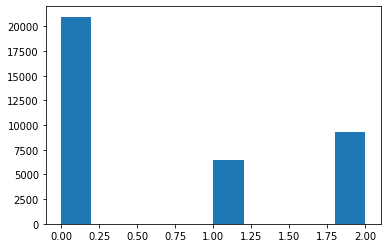

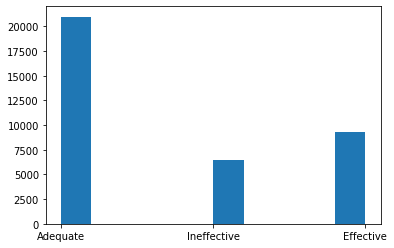

In [3]:
# Convert categorical variable into dummy variable and one-hot encoding
# For essayClass - we have one-hot vector and dummy variables too. One-hot vector essential for using with PCA
essayClassOneHot = pd.get_dummies(essayClass.discourse_type).to_numpy()
essayClassDummies = pd.factorize(essayClass.discourse_type)
essayClassDummies = essayClassDummies[0]
# For essayRating - only dummy variable are considered because we only use it for comparision and not for PCA
essayRatingDummies = pd.factorize(essayRating.discourse_effectiveness)
essayRatingDummies = essayRatingDummies[0]
print(essayClassOneHot.shape)
print(essayClassDummies.shape)
print(essayRatingDummies.shape)
plt.hist(essayRatingDummies)
plt.figure()
plt.hist(essayRating.discourse_effectiveness)

In [4]:
# Train-validation data split
X_train, X_test, y_train, y_test = train_test_split(np.concatenate((essayEncode,essayClassOneHot),axis=1),
                                                    essayRatingDummies, test_size=0.2, random_state=42, shuffle = True)
print(X_train.shape)
# Over-sample training data to make it balanced
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
# X_res, y_res = ros.fit_resample(np.concatenate((essayEncode,essayClassOneHot),axis=1), essayRatingDummies)
# X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, shuffle = True)

(29412, 775)


(array([16731.,     0.,     0.,     0.,     0., 16731.,     0.,     0.,
            0., 16731.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

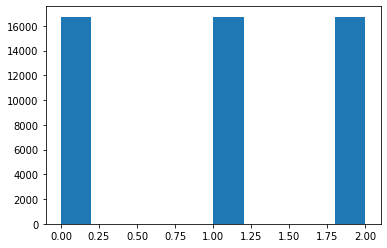

In [5]:
plt.hist(y_train)

In [6]:
print(X_train.shape)
print(X_test.shape)
X_super=np.concatenate((X_train, X_test), axis=0)
#Y_super=np.concatenate((y_train, y_test), axis=0)
print(X_super.shape)



(50193, 775)
(7353, 775)
(57546, 775)


In [7]:
# t-SNE on training data
tsne = TSNE(n_components=2, verbose=1)#,perplexity=10,metric = 'cityblock')
xTSNE = tsne.fit_transform(X_super)
xTSNE.shape


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 57546 samples in 0.062s...
[t-SNE] Computed neighbors for 57546 samples in 230.814s...
[t-SNE] Computed conditional probabilities for sample 1000 / 57546
[t-SNE] Computed conditional probabilities for sample 2000 / 57546
[t-SNE] Computed conditional probabilities for sample 3000 / 57546
[t-SNE] Computed conditional probabilities for sample 4000 / 57546
[t-SNE] Computed conditional probabilities for sample 5000 / 57546
[t-SNE] Computed conditional probabilities for sample 6000 / 57546
[t-SNE] Computed conditional probabilities for sample 7000 / 57546
[t-SNE] Computed conditional probabilities for sample 8000 / 57546
[t-SNE] Computed conditional probabilities for sample 9000 / 57546
[t-SNE] Computed conditional probabilities for sample 10000 / 57546
[t-SNE] Computed conditional probabilities for sample 11000 / 57546
[t-SNE] Computed conditional probabilities for sample 12000 / 57546
[t-SNE] Computed conditional probabilities for s

(57546, 2)

In [8]:
xTSNE_train, xTSNE_test = train_test_split(xTSNE, test_size=0.127776040037,shuffle = False)
#x_train, x_test = train_test_split(X_super, test_size=0.127776040037)
#Y_train, Y_test = train_test_split(Y_super, test_size=0.127776040037)


In [9]:
print(xTSNE_train.shape)
print(xTSNE_test.shape)

(50193, 2)
(7353, 2)


In [10]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=3, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


38.38782300320762
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.37      0.37      0.37     16731
  Inadequate       0.39      0.39      0.39     16731
   Effective       0.39      0.39      0.39     16731

    accuracy                           0.38     50193
   macro avg       0.38      0.38      0.38     50193
weighted avg       0.38      0.38      0.38     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.63      0.36      0.46      4246
  Inadequate       0.22      0.41      0.28      1282
   Effective       0.29      0.39      0.33      1825

    accuracy                           0.38      7353
   macro avg       0.38      0.39      0.36      7353
weighted avg       0.47      0.38      0.40      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [11]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=5, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


40.77461000537924
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.43      0.21      0.28     16731
  Inadequate       0.41      0.49      0.45     16731
   Effective       0.40      0.52      0.45     16731

    accuracy                           0.41     50193
   macro avg       0.41      0.41      0.39     50193
weighted avg       0.41      0.41      0.39     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.68      0.21      0.32      4246
  Inadequate       0.21      0.46      0.29      1282
   Effective       0.29      0.51      0.37      1825

    accuracy                           0.33      7353
   macro avg       0.39      0.39      0.33      7353
weighted avg       0.50      0.33      0.33      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [12]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=10, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


46.086107624569166
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.41      0.35      0.38     16731
  Inadequate       0.50      0.47      0.49     16731
   Effective       0.46      0.56      0.51     16731

    accuracy                           0.46     50193
   macro avg       0.46      0.46      0.46     50193
weighted avg       0.46      0.46      0.46     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.65      0.34      0.45      4246
  Inadequate       0.29      0.47      0.36      1282
   Effective       0.34      0.57      0.42      1825

    accuracy                           0.42      7353
   macro avg       0.43      0.46      0.41      7353
weighted avg       0.51      0.42      0.43      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
   

In [13]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=15, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


48.78568724722571
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.42      0.27      0.33     16731
  Inadequate       0.49      0.61      0.54     16731
   Effective       0.53      0.58      0.55     16731

    accuracy                           0.49     50193
   macro avg       0.48      0.49      0.47     50193
weighted avg       0.48      0.49      0.47     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.67      0.26      0.38      4246
  Inadequate       0.27      0.61      0.37      1282
   Effective       0.39      0.59      0.47      1825

    accuracy                           0.40      7353
   macro avg       0.44      0.49      0.41      7353
weighted avg       0.53      0.40      0.40      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [14]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=25, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


50.97523559062021
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.44      0.32      0.37     16731
  Inadequate       0.51      0.61      0.56     16731
   Effective       0.55      0.60      0.57     16731

    accuracy                           0.51     50193
   macro avg       0.50      0.51      0.50     50193
weighted avg       0.50      0.51      0.50     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.70      0.32      0.44      4246
  Inadequate       0.28      0.60      0.38      1282
   Effective       0.41      0.59      0.48      1825

    accuracy                           0.44      7353
   macro avg       0.46      0.50      0.43      7353
weighted avg       0.55      0.44      0.44      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [15]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=50, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


52.824098977945134
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.45      0.35      0.39     16731
  Inadequate       0.54      0.59      0.56     16731
   Effective       0.57      0.65      0.61     16731

    accuracy                           0.53     50193
   macro avg       0.52      0.53      0.52     50193
weighted avg       0.52      0.53      0.52     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.68      0.33      0.45      4246
  Inadequate       0.30      0.57      0.39      1282
   Effective       0.42      0.65      0.51      1825

    accuracy                           0.45      7353
   macro avg       0.46      0.52      0.45      7353
weighted avg       0.55      0.45      0.45      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
   

In [16]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=75, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


54.44583906122368
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.46      0.36      0.40     16731
  Inadequate       0.55      0.62      0.58     16731
   Effective       0.60      0.66      0.63     16731

    accuracy                           0.54     50193
   macro avg       0.54      0.54      0.54     50193
weighted avg       0.54      0.54      0.54     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.68      0.34      0.45      4246
  Inadequate       0.31      0.60      0.41      1282
   Effective       0.43      0.64      0.52      1825

    accuracy                           0.46      7353
   macro avg       0.47      0.53      0.46      7353
weighted avg       0.55      0.46      0.46      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [17]:
# PCA for for testing data
# K-Means on PCA-reduced data
kmeans = KMeans(n_clusters=100, random_state=0)
xLabs = kmeans.fit_predict(xTSNE_train)
xLabs_Test = kmeans.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


55.537624768394
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.48      0.35      0.40     16731
  Inadequate       0.57      0.62      0.59     16731
   Effective       0.59      0.70      0.64     16731

    accuracy                           0.56     50193
   macro avg       0.55      0.56      0.55     50193
weighted avg       0.55      0.56      0.55     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.69      0.34      0.46      4246
  Inadequate       0.31      0.59      0.41      1282
   Effective       0.43      0.68      0.53      1825

    accuracy                           0.47      7353
   macro avg       0.48      0.54      0.46      7353
weighted avg       0.56      0.47      0.47      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
      

In [18]:
from sklearn import mixture
#kmeans = mixture.GaussianMixture(n_components=3, covariance_type='full')
GMM = mixture.GaussianMixture(n_components=3, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


38.0650688342996
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.37      0.36      0.36     16731
  Inadequate       0.38      0.39      0.38     16731
   Effective       0.39      0.40      0.39     16731

    accuracy                           0.38     50193
   macro avg       0.38      0.38      0.38     50193
weighted avg       0.38      0.38      0.38     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.63      0.36      0.46      4246
  Inadequate       0.22      0.40      0.28      1282
   Effective       0.28      0.40      0.33      1825

    accuracy                           0.37      7353
   macro avg       0.37      0.38      0.36      7353
weighted avg       0.47      0.37      0.39      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
     

In [19]:

GMM = mixture.GaussianMixture(n_components=5, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))



41.77474946705716
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.43      0.20      0.28     16731
  Inadequate       0.42      0.53      0.47     16731
   Effective       0.41      0.52      0.46     16731

    accuracy                           0.42     50193
   macro avg       0.42      0.42      0.40     50193
weighted avg       0.42      0.42      0.40     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.68      0.20      0.31      4246
  Inadequate       0.22      0.52      0.31      1282
   Effective       0.29      0.50      0.37      1825

    accuracy                           0.33      7353
   macro avg       0.40      0.41      0.33      7353
weighted avg       0.51      0.33      0.32      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [20]:

GMM = mixture.GaussianMixture(n_components=10, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


46.56426194887733
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.39      0.58      0.47     16731
  Inadequate       0.57      0.38      0.46     16731
   Effective       0.51      0.44      0.47     16731

    accuracy                           0.47     50193
   macro avg       0.49      0.47      0.47     50193
weighted avg       0.49      0.47      0.47     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.63      0.57      0.60      4246
  Inadequate       0.34      0.37      0.35      1282
   Effective       0.37      0.43      0.40      1825

    accuracy                           0.50      7353
   macro avg       0.45      0.46      0.45      7353
weighted avg       0.52      0.50      0.51      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [21]:

GMM = mixture.GaussianMixture(n_components=15, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


48.652202498356345
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.43      0.26      0.33     16731
  Inadequate       0.49      0.61      0.54     16731
   Effective       0.52      0.58      0.55     16731

    accuracy                           0.49     50193
   macro avg       0.48      0.49      0.47     50193
weighted avg       0.48      0.49      0.47     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.67      0.26      0.37      4246
  Inadequate       0.27      0.61      0.38      1282
   Effective       0.38      0.60      0.47      1825

    accuracy                           0.40      7353
   macro avg       0.44      0.49      0.40      7353
weighted avg       0.53      0.40      0.40      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
   

In [22]:

GMM = mixture.GaussianMixture(n_components=25, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


51.19638196561274
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.45      0.35      0.39     16731
  Inadequate       0.55      0.53      0.54     16731
   Effective       0.53      0.66      0.58     16731

    accuracy                           0.51     50193
   macro avg       0.51      0.51      0.51     50193
weighted avg       0.51      0.51      0.51     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.69      0.34      0.46      4246
  Inadequate       0.31      0.52      0.38      1282
   Effective       0.39      0.66      0.49      1825

    accuracy                           0.45      7353
   macro avg       0.46      0.51      0.44      7353
weighted avg       0.55      0.45      0.45      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [23]:

GMM = mixture.GaussianMixture(n_components=50, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


53.32815332815333
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.44      0.35      0.39     16731
  Inadequate       0.54      0.64      0.58     16731
   Effective       0.60      0.61      0.60     16731

    accuracy                           0.53     50193
   macro avg       0.53      0.53      0.53     50193
weighted avg       0.53      0.53      0.53     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.66      0.34      0.45      4246
  Inadequate       0.30      0.62      0.40      1282
   Effective       0.43      0.59      0.50      1825

    accuracy                           0.45      7353
   macro avg       0.46      0.52      0.45      7353
weighted avg       0.54      0.45      0.45      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [24]:

GMM = mixture.GaussianMixture(n_components=75, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


54.33825433825434
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.46      0.35      0.39     16731
  Inadequate       0.55      0.61      0.58     16731
   Effective       0.59      0.67      0.63     16731

    accuracy                           0.54     50193
   macro avg       0.53      0.54      0.53     50193
weighted avg       0.53      0.54      0.53     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.68      0.33      0.45      4246
  Inadequate       0.31      0.59      0.40      1282
   Effective       0.43      0.66      0.52      1825

    accuracy                           0.46      7353
   macro avg       0.47      0.53      0.46      7353
weighted avg       0.55      0.46      0.46      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
    

In [25]:

GMM = mixture.GaussianMixture(n_components=100, covariance_type='full')
xLabs = GMM.fit_predict(xTSNE_train)
xLabs_Test = GMM.predict(xTSNE_test)
nLabs = np.unique(xLabs)
yPred = np.zeros(xLabs.shape[0])
yPred_Test = np.zeros(xLabs_Test.shape[0])
# Assign label to each cluster
for lab in nLabs:
    inds = np.where(xLabs==lab)[0]
    inds_test = np.where(xLabs_Test==lab)[0]
    trueLabels = y_train[inds]
    clusterLabel = stats.mode(trueLabels)[0]
    yPred[inds] = clusterLabel
#     print(clusterLabel)
    yPred_Test[inds_test] = clusterLabel
print(100*sum(yPred == y_train)/len(yPred))
print('Training: Metrics with oversampling')
print(classification_report(y_train,yPred,target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(y_test,yPred_Test,target_names=['Adequate','Inadequate','Effective']))

# Remove duplicates arising from oversampling in training data
dfTrain = np.concatenate((xTSNE_train,yPred[:,np.newaxis],y_train[:,np.newaxis]),axis = 1)
dfTest = np.concatenate((xTSNE_test,yPred_Test[:,np.newaxis],y_test[:,np.newaxis]),axis = 1)
dfTrain = pd.DataFrame(dfTrain)
dfTest = pd.DataFrame(dfTest)
print('Train data before removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
dfTrain.drop_duplicates(inplace=True)
# dfTest.drop_duplicates(inplace=True)
print('Train data after removing duplicates')
print(dfTrain.shape)
# print(dfTest.shape)
print('Training: Metrics with duplicates removed')
print(classification_report(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Validation: Metrics with no oversampling')
print(classification_report(dfTest.iloc[:,-1],dfTest.iloc[:,-2],target_names=['Adequate','Inadequate','Effective']))
print('Confusion matrix - validation')
print(confusion_matrix(dfTest.iloc[:,-1],dfTest.iloc[:,-2]))
print('Confusion matrix - training')
print(confusion_matrix(dfTrain.iloc[:,-1],dfTrain.iloc[:,-2]))


55.661147968840275
Training: Metrics with oversampling
              precision    recall  f1-score   support

    Adequate       0.47      0.37      0.42     16731
  Inadequate       0.57      0.62      0.59     16731
   Effective       0.60      0.68      0.64     16731

    accuracy                           0.56     50193
   macro avg       0.55      0.56      0.55     50193
weighted avg       0.55      0.56      0.55     50193

Validation: Metrics with no oversampling
              precision    recall  f1-score   support

    Adequate       0.70      0.36      0.48      4246
  Inadequate       0.32      0.60      0.42      1282
   Effective       0.44      0.67      0.53      1825

    accuracy                           0.48      7353
   macro avg       0.49      0.55      0.48      7353
weighted avg       0.57      0.48      0.48      7353

Train data before removing duplicates
(50193, 4)
Train data after removing duplicates
(38687, 4)
Training: Metrics with duplicates removed
   